# MIE451/1513 Decision Support System -- Data Science Solution

## Be sure to let us know:
i. what location you chose (and remember to sign up on Piazza so there are no duplicates),   Port Elgin

ii. what preprocessing steps you implemented: lower casing


In [ ]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## Pandas Settings
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zijianwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zijianwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zijianwang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zijianwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Q1

In [ ]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()



In [ ]:
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

data = pd.read_csv('reviews.csv', header=None, names=columnNames)
#data ['reviewColumn'] = data['reviewColumn'].apply(lambda row: clean(row))
hotelDF = data.copy()
reviews = data['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
data = pd.concat([data, reviewDF], axis=1).drop(columns='reviewColumn')

100%|██████████| 338/338 [00:00<00:00, 1389.64it/s]


## Q1 (a)

In [ ]:
hotel_averages = data.groupby('hotelName').mean()
hotel_averages

,ratingScore,vader
hotelName,,
All Seasons Motel,3.631579,0.620395
Aunt Mabel&#39;s Country Kitchen &amp; Motel,1.000000,0.031350
Kincardinite Motel,2.428571,0.210600
Lakeview Motel,4.400000,0.730700
Manor Motel,2.800000,0.619840
Maple Leaf Inn,2.933333,0.728673
Paradise Inn,4.846154,0.931285
Quality Inn,4.404255,0.830745
Save Inn,1.923077,0.208615


## Q1 (b)

In [ ]:
results_b = pd.DataFrame(columns=['top5_ground_truth',
                                  'bottom5_ground_truth',
                                  'top5_vader',
                                  'bottom5_vader'])


results_b['top5_ground_truth'] = hotel_averages.sort_values(by="ratingScore", ascending=False).index[:5]
results_b['bottom5_ground_truth'] = hotel_averages.sort_values(by="ratingScore", ascending=True).index[:5]

results_b['top5_vader'] = hotel_averages.sort_values(by="vader", ascending=False).index[:5]
results_b['bottom5_vader'] = hotel_averages.sort_values(by="vader", ascending=True).index[:5]

results_b.sort_index(axis=1)

,bottom5_ground_truth,bottom5_vader,top5_ground_truth,top5_vader
0,Aunt Mabel&#39;s Country Kitchen &amp; Motel,Stop 21 Motel,The George House,The George House
1,Save Inn,Aunt Mabel&#39;s Country Kitchen &amp; Motel,Paradise Inn,Paradise Inn
2,Stop 21 Motel,Save Inn,Super 8 by Wyndham Port Elgin,Quality Inn
3,Kincardinite Motel,Kincardinite Motel,Quality Inn,Super 8 by Wyndham Port Elgin
4,Manor Motel,TownePlace Suites by Marriott Kincardine,Lakeview Motel,Lakeview Motel


# Q2

## Q2 (a)

In [ ]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords=None):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    if kwords:
        topk = counter.most_common(kwords)
    else: #give all words
        topk = counter.most_common()
        
    return topk

In [ ]:
getTopKWords(data.loc[data['groundTruth']=='positive'], 50)

[('clean', 175),
 ('breakfast', 151),
 ('great', 144),
 ('stayed', 94),
 ('friendly', 91),
 ('nice', 91),
 ('beach', 79),
 ('would', 78),
 ('place', 75),
 ('comfortable', 67),
 ('well', 66),
 ('pool', 65),
 ('one', 63),
 ('area', 60),
 ('good', 56),
 ('back', 53),
 ('super', 49),
 ('beds', 46),
 ('motel', 45),
 ('hot', 44),
 ('time', 43),
 ('town', 43),
 ('location', 43),
 ('inn', 42),
 ('close', 42),
 ('new', 41),
 ('recommend', 40),
 ('definitely', 38),
 ('everything', 37),
 ('like', 36),
 ('helpful', 36),
 ('beautiful', 36),
 ('night', 34),
 ('service', 34),
 ('could', 33),
 ('always', 32),
 ('u2026', 32),
 ('front', 31),
 ('away', 31),
 ('two', 31),
 ('port', 31),
 ('elgin', 31),
 ('spacious', 30),
 ('desk', 29),
 ('make', 29),
 ('get', 29),
 ('family', 28),
 ('nthe', 28),
 ('weekend', 28),
 ('excellent', 28)]

In [ ]:
getTopKWords(data.loc[data['groundTruth']=='negative'], 50)

[('would', 57),
 ('clean', 46),
 ('one', 44),
 ('night', 39),
 ('good', 38),
 ('motel', 37),
 ('like', 32),
 ('breakfast', 30),
 ('place', 28),
 ('get', 27),
 ('pool', 26),
 ('back', 23),
 ('old', 23),
 ('nthe', 23),
 ('u2019s', 23),
 ('new', 22),
 ('even', 22),
 ('stayed', 21),
 ('u2019t', 21),
 ('front', 20),
 ('door', 20),
 ('marriott', 20),
 ('dirty', 20),
 ('desk', 19),
 ('need', 19),
 ('kincardine', 19),
 ('price', 19),
 ('also', 18),
 ('shower', 18),
 ('bed', 18),
 ('booked', 18),
 ('area', 18),
 ('first', 17),
 ('bathroom', 16),
 ('well', 16),
 ('everything', 16),
 ('people', 16),
 ('told', 15),
 ('could', 15),
 ('fridge', 15),
 ('beach', 15),
 ('check', 15),
 ('went', 15),
 ('got', 15),
 ('two', 15),
 ('last', 15),
 ('times', 15),
 ('location', 15),
 ('another', 15),
 ('friendly', 15)]

**Analysis**:

Location specific words are 'port', 'elgin', and 'kincardine'. They are specified to the location Port Elgin and nearby place.

'breakfast','night', 'time','pool' and 'beach' appear in both positive and negative reviews. This makes sense since they are objective existence that people could either like it or dislike it.

The words 'good', 'clean' and 'friendly' also appear in negative reviews which is kind of surprising. However, their frequency is much lower than those in positive reviews.

## Q2 (b)

In [ ]:
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

chunker = nltk.RegexpParser(grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

def getTopKNP(df, kNPs=None):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    if kNPs:
        topk = counter.most_common(kNPs)
    else:
        topk = counter.most_common()
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


Top 50 Positive Noun Phrases


In [ ]:
getTopKNP(data.loc[data['groundTruth']=='positive'], 50)

[('port elgin', 22),
 ('front desk', 13),
 ('hot tub', 10),
 ('windspir inn', 8),
 ('indoor pool', 7),
 ('great time', 7),
 ('outdoor pool', 7),
 ('qualiti inn', 7),
 ('saubl beach', 6),
 ('next time', 6),
 ('minut drive', 5),
 ('lake huron', 5),
 ('short drive', 5),
 ('great place', 5),
 ('breakfast area', 4),
 ('main street', 4),
 ('bruce peninsula', 4),
 ('short walk', 3),
 ('tim horton', 3),
 ('groceri store', 3),
 ('buffet breakfast', 3),
 ('hot breakfast', 3),
 ('king suit', 3),
 ('wonder experi', 3),
 ('larg group', 3),
 ('free breakfast', 3),
 ('queen bed', 3),
 ('long weekend', 3),
 ('super clean', 3),
 ('southampton beach', 3),
 ('local eateri', 3),
 ('continent breakfast', 3),
 ('last minut', 3),
 ('host jerri', 3),
 ('canadian tire', 2),
 ('complimentari breakfast', 2),
 ('good addit', 2),
 ('full kitchen', 2),
 ('styrofoam plate', 2),
 ('great visit', 2),
 ('u002fc unit', 2),
 ('sofa bed', 2),
 ('next year', 2),
 ('recent visit', 2),
 ('king bed', 2),
 ('ga station', 2),
 

Top 50 Negative Noun Phrases

In [ ]:
getTopKNP(data.loc[data['groundTruth']=='negative'], 50)

[('front desk', 11),
 ('park lot', 4),
 ('next morn', 3),
 ('air condition', 3),
 ('shower curtain', 2),
 ('long weekend', 2),
 ('free breakfast', 2),
 ('holiday inn express', 2),
 ('great locat', 2),
 ('multipl time', 2),
 ('first night', 2),
 ('low end', 2),
 ('hot tub', 2),
 ('hand towel', 2),
 ('cheap place', 2),
 ('busi peopl', 2),
 ('juli long weekend', 2),
 ('port elgin', 2),
 ('gov rate', 2),
 ('aunt mabl', 2),
 ('park spot', 2),
 ('stale smoke', 2),
 ('front door', 2),
 ('desper need', 2),
 ('second night', 2),
 ('hour drive', 2),
 ('lake huron', 2),
 ('bruce peninsula park', 2),
 ('musti smell', 2),
 ('minut walk', 2),
 ('hair dryer', 2),
 ('mini fridg', 2),
 ('daili clean', 1),
 ('full garbag pail', 1),
 ('fresh one', 1),
 ('decent size fridg medium size', 1),
 ('cubic foot', 1),
 ('decent freezer', 1),
 ('ice pack', 1),
 ('coffe maker', 1),
 ('larg round u00a0 flat coffe filter', 1),
 ('u2019t use', 1),
 ('buffet coffe', 1),
 ('good size sink', 1),
 ('cloth washcloth', 1),


**Analysis**: Phrases such as 'front desk', ' free breakfast' and 'next time' and   appear in both positive and negative reviews. It make sense that both positive and negative reviews will refer to those subject. 

I did not expect the phrase 'last minut' to appear in positive reviews as it is not a common complimentary word. The reasone why it appaears maybe the hotel save or accept the guest at last minute, that's why that result in a positive review.

## Q2 (c)

In [ ]:
grammar = r"""
    NBAR: 
        {<DT>?<NN.*|JJ>*<NN|NNS|NNP|NNPS>+}
    
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

Positive

In [ ]:
getTopKNP(data.loc[data['groundTruth']=='positive'], 50)

[('port elgin', 22),
 ('front desk', 13),
 ('hot tub', 10),
 ('windspir inn', 8),
 ('indoor pool', 7),
 ('great time', 7),
 ('outdoor pool', 7),
 ('qualiti inn', 7),
 ('saubl beach', 6),
 ('next time', 6),
 ('minut drive', 5),
 ('lake huron', 5),
 ('short drive', 5),
 ('great place', 5),
 ('breakfast area', 4),
 ('main street', 4),
 ('bruce peninsula', 4),
 ('short walk', 3),
 ('tim horton', 3),
 ('groceri store', 3),
 ('buffet breakfast', 3),
 ('hot breakfast', 3),
 ('king suit', 3),
 ('wonder experi', 3),
 ('larg group', 3),
 ('free breakfast', 3),
 ('queen bed', 3),
 ('long weekend', 3),
 ('super clean', 3),
 ('southampton beach', 3),
 ('local eateri', 3),
 ('continent breakfast', 3),
 ('last minut', 3),
 ('host jerri', 3),
 ('canadian tire', 2),
 ('complimentari breakfast', 2),
 ('good addit', 2),
 ('full kitchen', 2),
 ('styrofoam plate', 2),
 ('great visit', 2),
 ('u002fc unit', 2),
 ('sofa bed', 2),
 ('everi time', 2),
 ('next year', 2),
 ('recent visit', 2),
 ('king bed', 2),
 

Negative

In [ ]:
getTopKNP(data.loc[data['groundTruth']=='negative'], 50)

[('front desk', 11),
 ('everi time', 4),
 ('park lot', 4),
 ('anoth sign', 4),
 ('next morn', 3),
 ('air condition', 3),
 ('shower curtain', 2),
 ('long weekend', 2),
 ('free breakfast', 2),
 ('holiday inn express', 2),
 ('great locat', 2),
 ('multipl time', 2),
 ('first night', 2),
 ('low end', 2),
 ('hot tub', 2),
 ('hand towel', 2),
 ('cheap place', 2),
 ('busi peopl', 2),
 ('juli long weekend', 2),
 ('port elgin', 2),
 ('gov rate', 2),
 ('aunt mabl', 2),
 ('park spot', 2),
 ('stale smoke', 2),
 ('front door', 2),
 ('desper need', 2),
 ('second night', 2),
 ('hour drive', 2),
 ('lake huron', 2),
 ('bruce peninsula park', 2),
 ('musti smell', 2),
 ('minut walk', 2),
 ('hair dryer', 2),
 ('mini fridg', 2),
 ('daili clean', 1),
 ('full garbag pail', 1),
 ('fresh one', 1),
 ('decent size fridg medium size', 1),
 ('cubic foot', 1),
 ('decent freezer', 1),
 ('ice pack', 1),
 ('coffe maker', 1),
 ('larg round u00a0 flat coffe filter', 1),
 ('u2019t use', 1),
 ('buffet coffe', 1),
 ('good s

**Remarks**  

Similarity: both my grammar and 2(b) gives very similar result for positive result and the top 5 are both 'port elgin', 'front desk', 'hot tub', 'windspir inn' and 'indoor pool'.

Difference: For negative reviews, my grammar adds 'everi time', 'anoth sign', which makes more sense to me since 'anoth sign' is a negitive noun pharse people tend to use when giving negative reviews.


# Q3

## Q3 (a) Pointwise MI

In [ ]:
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


def getMI(topk, finaldf, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [ ]:
topk = getTopKWords(reviewDF)
finaldf = dataFrameTransformation(hotelDF, reviewDF, topk)
getMI(topk,finaldf).head(50)

,Word,MI Score
130,dirty,0.059083
2,great,0.050838
321,stained,0.035945
138,marriott,0.035945
63,old,0.030913
172,said,0.029374
118,first,0.028753
1,breakfast,0.027542
499,carpets,0.023733
553,musty,0.023733


**Analysis** The words 'dirty', 'great', 'stained','marriott' and 'old' have the highest MI score, and it makes sense. Since they are very relevant to the sentiment of the review. For Marriot, I think it's because Marriot had a very high reputation and people tend to rate higher.

## Q3 (b) Phrase MI

In [ ]:
topk_phrase = getTopKNP(data, 50)
finaldf_phrase = NPdataFrameTransformation(hotelDF, reviewDF, topk_phrase)
display(getMI(topk_phrase,finaldf_phrase).head(50))

## Negative 
print('Negative')
topk_phrase = getTopKNP(data.loc[data['groundTruth']=='negative'], 50)
finaldf_phrase = NPdataFrameTransformation(hotelDF.loc[hotelDF['groundTruth']=='negative'], reviewDF, topk_phrase)
display(getMI(topk_phrase,finaldf_phrase).head(10))



,Word,MI Score
30,next morn,0.011755
38,air condition,0.011755
1,port elgin,0.007563
5,indoor pool,0.006576
7,great time,0.006576
8,qualiti inn,0.006576
11,everi time,0.006215
16,park lot,0.006003
10,saubl beach,0.005627
12,next time,0.005627


Negative


,Word,MI Score
0,front desk,0.0
37,decent size fridg medium size,0.0
27,hour drive,0.0
28,lake huron,0.0
29,bruce peninsula park,0.0
30,musti smell,0.0
31,minut walk,0.0
32,hair dryer,0.0
33,mini fridg,0.0
34,daili clean,0.0


**Analysis** The word 'next morn' has the highest MI values. Based on the MI of negative words and sentiment, I recommend the hotel to improve 'air condition' and the 'musty smell'

# Q4

## Q4 (a)

In [ ]:
def demo_pmiCal(df,word):
    pmilist=[]
    N = df.shape[0]
    for sentiment in ['positive','negative']:
        for word_present in [False,True]:
            px = sum(df['groundTruth']==sentiment)
            py = sum(df[word]==word_present)
            pxy = len(df[(df['groundTruth']==sentiment) & (df[word]==word_present)])

            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)*N/(px*py))
            else:
                pmi = math.log(pxy*N/(px*py))

            pmilist.append([sentiment]+[word_present]+[px]+[py]+[pxy]+[pmi])

    # assemble the results into a dataframe
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['sentiment (x)','word_present (y)','px','py','pxy','pmi']
    return pmidf

# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    try:
    
        N = df.shape[0]

        px = sum(df[label_column]==gt_sentiment)
        py = sum(df[word]==True)
        pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

        if pxy==0:#Log 0 cannot happen
            pmi = math.log((pxy+0.0001)*N/(px*py))
        else:
            pmi = math.log(pxy*N/(px*py))
        return pmi
    except:
        return np.nan

#### (i) Positive

In [ ]:
topk = getTopKWords(reviewDF, 1000) #sticking to upper bound of 1000 words
finaldf = dataFrameTransformation(hotelDF, reviewDF, topk)
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
display(pmiposdf.sort_values(by='pmi', ascending=False).head(50))

100%|██████████| 1000/1000 [00:00<00:00, 1396.48it/s]


,pmi
enjoyable,0.313658
beyond,0.313658
jenn,0.313658
shape,0.313658
busy,0.313658
fire,0.313658
outdoors,0.313658
attending,0.313658
warmer,0.313658
happy,0.313658


#### (ii) Negative

In [ ]:
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 1000/1000 [00:00<00:00, 1826.24it/s]


,pmi
1st,1.312186
stains,1.312186
damage,1.312186
u00a0,1.312186
credit,1.312186
green,1.312186
updating,1.312186
nwhen,1.312186
pulled,1.312186
unkept,1.312186


**Comments**: 
1. For positive reveiws, the PMI value makes sense since the words are all positive word. Foe e.g. the word 'enjoyable' and 'beyond', they are mostly used in positive setting.

2. for negative reviews, most of the words are negative themselves. For e.g. 'stains' and 'damage', they are mostly used in negative situations.

3. There are some locale specific terms founded in the list, such as 'outdoors', 'patio' and 'sobeys', maybe having a supermarket nearby is very convenient for the customers. Interestingly, the word 'jenn' ranks third in the positive list, maybe it's because jenny is very helpful and receives many compliments from customers.

## Q4 (b)

#### (i) Positive

In [ ]:
topk_phrase = getTopKNP(reviewDF, 1000) #sticking to upper bound of 1000 noun phrases
finaldf_phrase = NPdataFrameTransformation(hotelDF, reviewDF, topk_phrase)
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'positive')
pmiposdf_phrase.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 1000/1000 [00:00<00:00, 1808.86it/s]


,pmi
bagel sausag,0.313658
great time pool,0.313658
busi trip,0.313658
bruce power plant,0.313658
wonder friendli,0.313658
love thank super,0.313658
firm husband,0.313658
waa clean bed,0.313658
awesom everyth,0.313658
dump water bucket,0.313658


#### (ii) Negative

In [ ]:
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'negative')
pmiposdf_phrase.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 1000/1000 [00:00<00:00, 1733.06it/s]


,pmi
googl review,1.312186
mani thing,1.312186
shock someon,1.312186
kitchen breakfast supervisor,1.312186
garbag bin,1.312186
waffl everyth,1.312186
health violat,1.312186
foot shower,1.312186
manag last year,1.312186
dishwash puck,1.312186


**Comments**: Overall, the terms generated using PMI makes much more sense than with MI.

1. For positive reveiws, most of the words rank high have positive meaning such as "bagel sausage", 'greeat time pool' and 'busi trip'

2. for negative reviews, most of the words are negative themselves. For e.g. 'shock someone' and 'health violat', and they are mostly used in negative situations.

Interestingly, the phrase 'kitchen breakfast supervisor' appeared as the 4th on the negative review list, that is because there was one review complaining about the bad food to the supervisor.

Again, we also see some locale-specific term from the positive list, such as  "bruce power plant", which is a place near Port Elgin

## Q4 (c)

In [ ]:
hotelDF['hotelName'].unique()

array(['TownePlace Suites by Marriott Kincardine', 'All Seasons Motel',
       'Paradise Inn', 'Super 8 by Wyndham Port Elgin',
       'Aunt Mabel&#39;s Country Kitchen &amp; Motel', 'The George House',
       'Southsider Motel', 'Kincardinite Motel', 'Stop 21 Motel',
       'Lakeview Motel', 'Maple Leaf Inn', 'Quality Inn', 'Windspire Inn',
       'Save Inn', 'Manor Motel'], dtype=object)

### (c)

Top Hotel: Paradise Inn

Bottom Hotel: Save Inn 

##### Positive, Words

In [ ]:
topHotelDF = hotelDF.loc[(hotelDF['hotelName']=="Paradise Inn") | (hotelDF['hotelName']=="Save Inn")]
topReviewDF = reviewDF.reindex(topHotelDF.index)

topHotelDF = topHotelDF.reset_index(drop=True)
topReviewDF = topReviewDF.reset_index(drop=True)

topk = getTopKWords(topReviewDF, 1000)
finaldf = dataFrameTransformation(topHotelDF, topReviewDF, topk)
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
pmiposdf.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 530/530 [00:00<00:00, 2090.74it/s]


,pmi
delicious,0.619039
cottage,0.619039
toasted,0.619039
nhad,0.619039
love,0.619039
locals,0.619039
tell,0.619039
nyou,0.619039
portions,0.619039
yards,0.619039


##### Negative, Words

In [ ]:
pminegdf = pmiForAllCal(finaldf,topk,'negative').fillna(0)
pminegdf.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 530/530 [00:00<00:00, 1710.01it/s]


,pmi
saturday,0.77319
crowbar,0.77319
maintenance,0.77319
inside,0.77319
sad,0.77319
trim,0.77319
carpets,0.77319
hover,0.77319
lamp,0.77319
zink,0.77319


##### Positive, NPs

In [ ]:
topHotelDF = hotelDF.loc[(hotelDF['hotelName']=="Paradise Inn") | (hotelDF['hotelName']=="Save Inn")]
topReviewDF = reviewDF.reindex(topHotelDF.index)
topHotelDF = topHotelDF.reset_index(drop=True)
topReviewDF = topReviewDF.reset_index(drop=True)
topk_phrase = getTopKNP(topReviewDF, 1000)
finaldf_phrase = NPdataFrameTransformation(topHotelDF, topReviewDF, topk_phrase)
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'positive')
pmiposdf_phrase.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 144/144 [00:00<00:00, 2107.27it/s]


,pmi
port elgin,0.619039
great night,0.619039
pleasant kitchen,0.619039
great view,0.619039
amaz place,0.619039
short stroll,0.619039
wonder nattract food entertain,0.619039
harbour sunset,0.619039
port elgin right,0.619039
motel u002f guest hous,0.619039


##### Negative, NPs

In [ ]:
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'negative')
pmiposdf_phrase.sort_values(by='pmi', ascending=False).head(50)

100%|██████████| 144/144 [00:00<00:00, 2110.54it/s]


,pmi
saturday night,0.77319
min hard,0.77319
cleanli first,0.77319
cell phone,0.77319
handl washroom,0.77319
u2019t recommend,0.77319
speak english,0.77319
horror movi,0.77319
pet friendli,0.77319
minut walk,0.77319


##### review

**Analysis**: The top hotel for Port Elgin is "Paradise Inn", and the bottom hotel is "Save Inn".

From the good reviews ranking by the PMI we know that the top pharses are 'great view', 'pleasant kitchen' and 'harbour sunset'. The customers value the kitchen, the view, the sunset beach a lot.

From the negative reviews ranking by the PMI
'cleanli first' and 'handl washroom', 'huge bug' and 'tv suck'.

We know that, the customers don't like the hotel since it's not clean and there are bugs around, and the tv is not funtioning well.


# Q5

**Note** Remember to save a static image of the map in the notebook

### (a) Histogram

In [ ]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

#### (i)

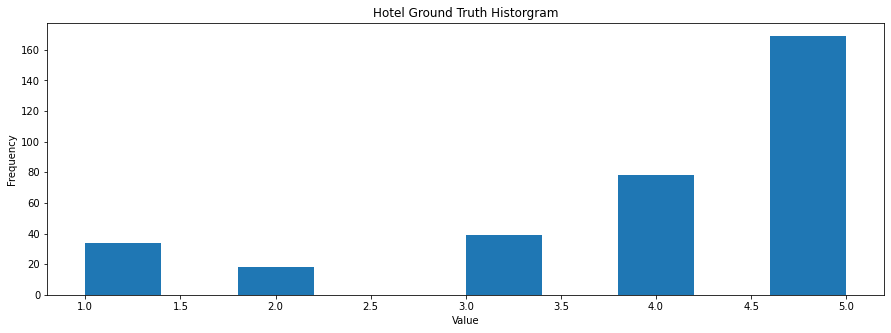

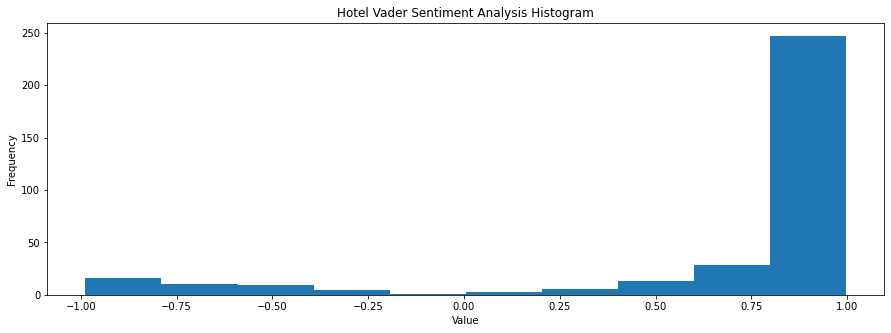

In [ ]:
getHistogram(data,'ratingScore', 'Hotel Ground Truth Historgram', figsize=(15, 5))
getHistogram(data,'vader', 'Hotel Vader Sentiment Analysis Histogram', figsize=(15, 5))

**Discussion**  

The distribution of ground truth and vader sentiment scores are very similar expecially for the high ground truth rating part such as 4.0 and 5.0. however, for 3.0 there are some difference where the vader frequecy is lower.

This does not surprise me since valder scale value is from -1 to 1, wheras the true rating scale have only 5 values.

#### (ii)

show a histogram of the number of reviews per hotel. Do you notice any specific trends or are no trends apparent?

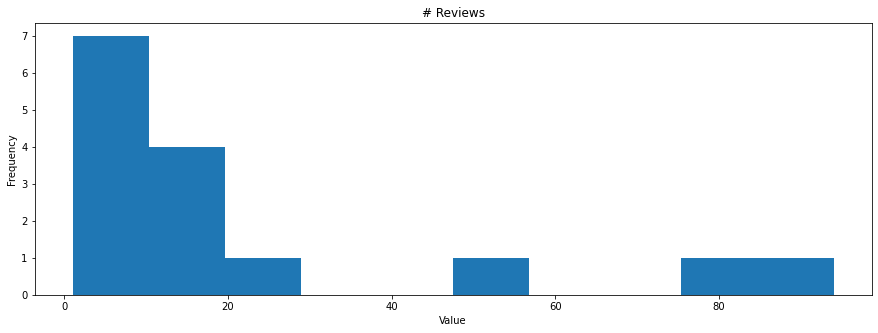

In [ ]:
getHistogram(data.groupby('hotelName').count().iloc[:, 0].to_frame('counts'),'counts', '# Reviews', figsize=(15, 5))

**Discussion**  

A decreasing trend is discovered that there are less and less hotels could get many reviews. It is probably because most people tend to not leave a review if the hotel is ok and either not too good or bad.

### (b) Box-Plots

#### (i)

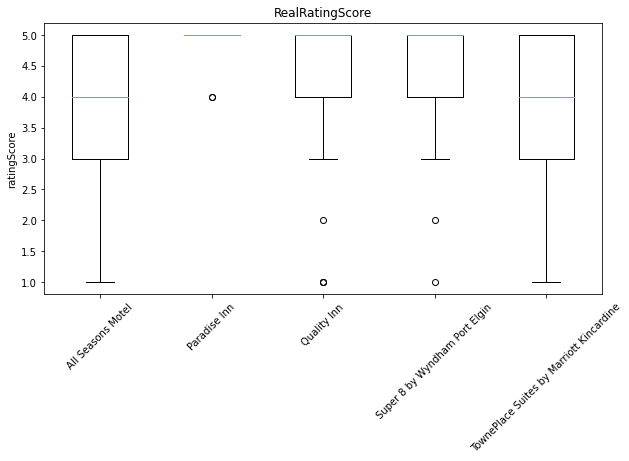

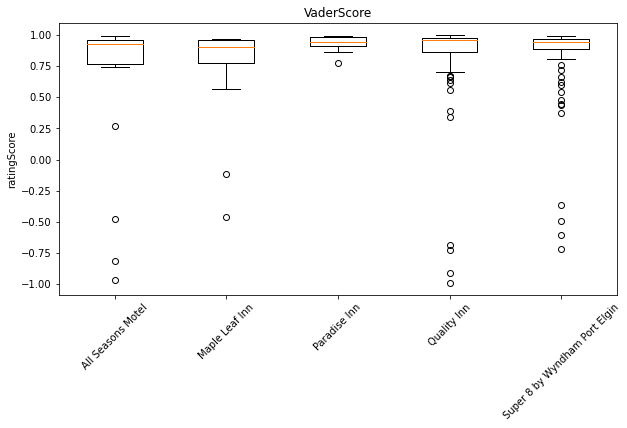

In [ ]:
def avg_rating_per_hotel(df):
    tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
    tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
    tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
    return tempDf


avg_rating_df = avg_rating_per_hotel(data)

five_hotels = avg_rating_df[avg_rating_df['n_reviews'] > 10].sort_values(by='AverageRatingScore', ascending=False).iloc[:5, :]
five_hotels = sorted(five_hotels.index.values)
five_hotels_rating = five_hotels
hotel_list = []
for hotel in five_hotels:
    _hotel = data.loc[data['hotelName'] == hotel]['ratingScore']
    hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('ratingScore')
plt.title('RealRatingScore')
plt.show()

five_hotels = avg_rating_df[avg_rating_df['n_reviews'] > 10].sort_values(by='AverageVader', ascending=False).iloc[:5, :]
five_hotels = sorted(five_hotels.index.values)
five_hotels_vader = five_hotels
hotel_list = []
for hotel in five_hotels:
    _hotel = data.loc[data['hotelName'] == hotel]['vader']
    hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('ratingScore')
plt.title('VaderScore')
plt.show()

#### (ii)

In [ ]:
pd.concat([data.loc[data['hotelName'].isin(five_hotels_rating), ['hotelName', 'ratingScore']].groupby('hotelName').mean(),
            data.loc[data['hotelName'].isin(five_hotels_rating), ['hotelName', 'ratingScore']].groupby('hotelName').var().fillna(0),
            data.loc[data['hotelName'].isin(five_hotels_vader), ['hotelName', 'vader']].groupby('hotelName').mean(),
            data.loc[data['hotelName'].isin(five_hotels_vader), ['hotelName', 'vader']].groupby('hotelName').var().fillna(0)],
            keys = ['Mean Rating', 'Variance Rating', 'Mean Vader', 'Variance Vader'], axis=1).droplevel(1, axis=1)

,Mean Rating,Variance Rating,Mean Vader,Variance Vader
hotelName,,,,
All Seasons Motel,3.631579,2.023392,0.620395,0.405411
Paradise Inn,4.846154,0.141026,0.931285,0.003757
Quality Inn,4.404255,0.824068,0.830745,0.139833
Super 8 by Wyndham Port Elgin,4.607595,0.574813,0.818763,0.120925
TownePlace Suites by Marriott Kincardine,3.711538,1.660256,NaN,NaN
Maple Leaf Inn,NaN,NaN,0.728673,0.186293


#### (iii)

**Discussion**  
 I think mean and variance are more informative, for example the paradise Inn box show very little information, but the Mean and varaiance give more info.

### (c) Scatterplots/Heatmaps

#### (i)

<ipython-input-40-ae0e4a9fc261>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  b1 = ax[1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)


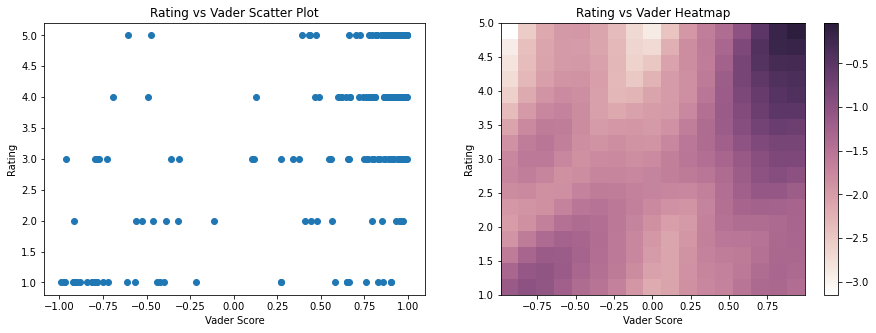

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)

rating_scores = data['ratingScore'].values
vader_scores = data['vader'].values

ax[0].plot(vader_scores, rating_scores,"o")
ax[0].set_title('Rating vs Vader Scatter Plot')

k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
fig.colorbar(b1, ax=ax[1])

ax[1].set_xlim(vader_scores.min(), vader_scores.max())
ax[1].set_ylim(rating_scores.min(), rating_scores.max())
ax[1].set_title('Rating vs Vader Heatmap')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

**Discussion**  

Vadar and real reatings tend to agree with each other for the extreme reatings either very good or very bad.

When the sentiment analysis (vadar) is low, the real rating could be high. This could be the reason that some users use negative words when giving reveiws but overall the score is high. OR the user mention negative things about other irrelevant things for the review.



#### (ii)

<ipython-input-41-2b59e62b693e>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  b1 = ax[0, 1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
<ipython-input-41-2b59e62b693e>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  b1 = ax[1, 1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)


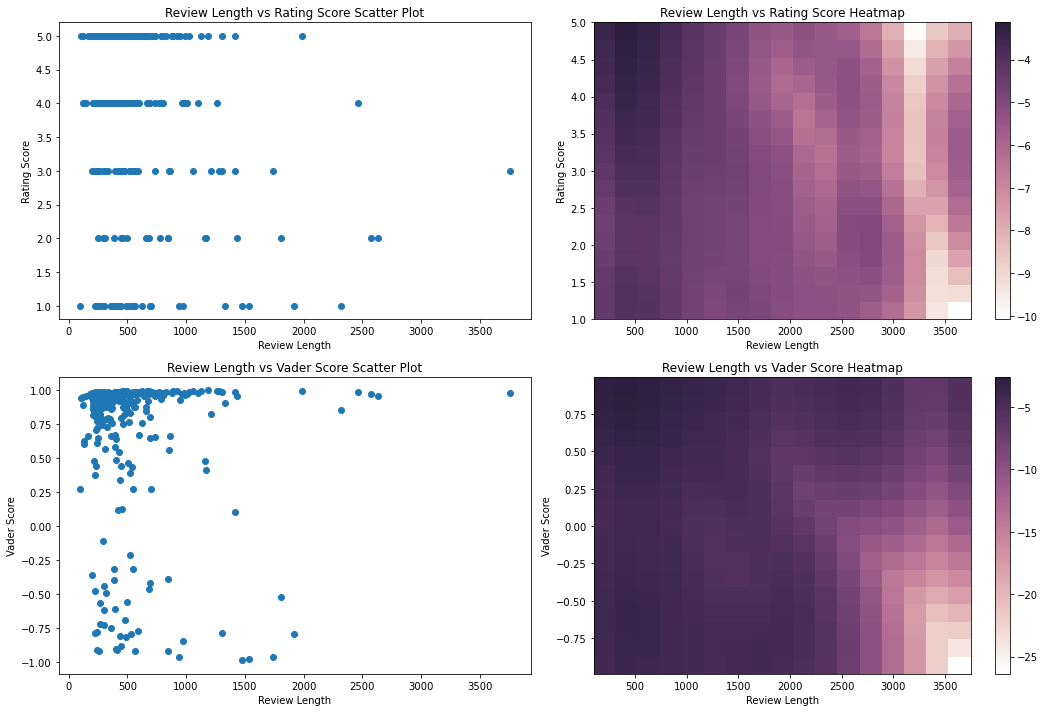

In [ ]:
rating_scores = data['ratingScore'].values
vader_scores = data['vader'].values
review_lengths = data['reviewCol'].str.len().values
fig, ax = plt.subplots(2,2,figsize=(15,10),sharex=False,sharey=False)

# review len vs rating score
ax[0, 0].plot(review_lengths, rating_scores,"o")
ax[0, 0].set_title('Review Length vs Rating Score Scatter Plot')

k = gaussian_kde(np.vstack([review_lengths, rating_scores]))
xi, yi = np.mgrid[review_lengths.min():review_lengths.max():review_lengths.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[0, 1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
fig.colorbar(b1, ax=ax[0, 1])

ax[0, 1].set_xlim(review_lengths.min(), review_lengths.max())
ax[0, 1].set_ylim(rating_scores.min(), rating_scores.max())
ax[0, 1].set_title('Review Length vs Rating Score Heatmap')

for _ax in ax[0]:
    _ax.set_xlabel('Review Length')
    _ax.set_ylabel('Rating Score')
    
    
# review len vs vader
ax[1, 0].plot(review_lengths, vader_scores,"o")
ax[1, 0].set_title('Review Length vs Vader Score Scatter Plot')

k = gaussian_kde(np.vstack([review_lengths, vader_scores]))
xi, yi = np.mgrid[review_lengths.min():review_lengths.max():review_lengths.size**0.5*1j,vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
b1 = ax[1, 1].pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
fig.colorbar(b1, ax=ax[1, 1])

ax[1, 1].set_xlim(review_lengths.min(), review_lengths.max())
ax[1, 1].set_ylim(vader_scores.min(), vader_scores.max())
ax[1, 1].set_title('Review Length vs Vader Score Heatmap')

for _ax in ax[1]:
    _ax.set_xlabel('Review Length')
    _ax.set_ylabel('Vader Score')
    
plt.tight_layout()
plt.show()

**Comments**  

Normally the review length and real score have a uniform distribution, that the length doesn't deternimne the score given where no clear trend is identified.

However, for the vader score, reviews that with very short words tend to generate very high score.

#### (iii)

Text(0, 0.5, 'Average Vader Rating')

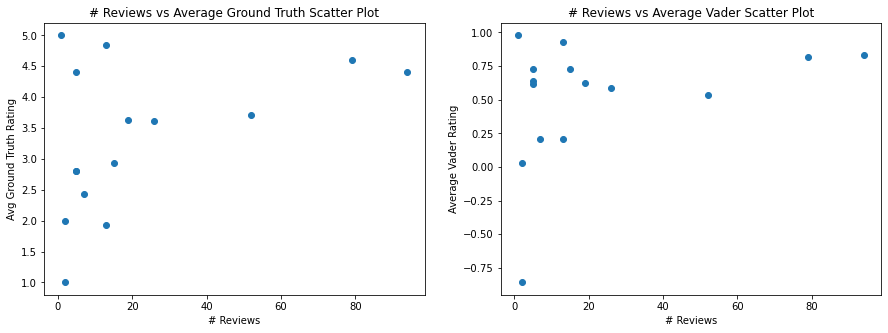

In [ ]:
data_agg = data[['hotelName', 'ratingScore', 'vader']].groupby('hotelName').agg({
                                                                                'ratingScore': ['count', 'mean'],
                                                                                'vader': ['count', 'mean']
                                                                            })
numReviews = data_agg['ratingScore']['count'].values
avgRating = data_agg['ratingScore']['mean'].values
avgVader = data_agg['vader']['mean'].values

fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
ax[0].plot(numReviews, avgRating,"o")
ax[0].set_title('# Reviews vs Average Ground Truth Scatter Plot')
ax[0].set_xlabel('# Reviews')
ax[0].set_ylabel('Avg Ground Truth Rating')

ax[1].plot(numReviews, avgVader,"o")
ax[1].set_title('# Reviews vs Average Vader Scatter Plot')
ax[1].set_xlabel('# Reviews')
ax[1].set_ylabel('Average Vader Rating')

**Discussion**  

Both the average ground truth rating and vader rating have similar distribution regarding to # of reviews.

There is one special case that Vader give negative score, this is consistent to (b) since most vadar score is positive.

### (d)

In [ ]:
def avg_rating_per_hotel(df):
    # average the scores over all hotels, you may need to provide additional filtering
    tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
    tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
    tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
    return tempDf

def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']


avg_rating_df = avg_rating_per_hotel(data)
geo_rating_df = avg_rating_df\
                         .join(hotelDF.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)

# 0 - need to give the tool a generic name.
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else (None, None, None))
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)


RateLimiter caught an error, retrying (0/2 tries). Called with (*("760 Goderich St Highway 21 North, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopy/adapters.py", line 438, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopy/adapters.py", line 466, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 403

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopy/extra/rate_limiter.py", line 136

RateLimiter caught an error, retrying (1/2 tries). Called with (*("5084 Highway 21, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 1345, in getresponse
    response.begin()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/zijianw

RateLimiter caught an error, retrying (0/2 tries). Called with (*("319 Kincardine Ave, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 1345, in getresponse
    response.begin()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/ziji

RateLimiter swallowed an error after 2 retries. Called with (*("319 Kincardine Ave, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 1345, in getresponse
    response.begin()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/zijianw

RateLimiter swallowed an error after 2 retries. Called with (*("378 Queen St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 1345, in getresponse
    response.begin()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Users/zijianwang/op

RateLimiter swallowed an error after 2 retries. Called with (*("183 Palmerston St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/en

RateLimiter caught an error, retrying (1/2 tries). Called with (*("481 Broadway St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/e

RateLimiter caught an error, retrying (0/2 tries). Called with (*("188 Mill Street, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/e

RateLimiter swallowed an error after 2 retries. Called with (*("188 Mill Street, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/envs

RateLimiter caught an error, retrying (1/2 tries). Called with (*("100 North Rankin St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anacond

RateLimiter caught an error, retrying (0/2 tries). Called with (*("1111 Sutton St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/en

RateLimiter swallowed an error after 2 retries. Called with (*("1111 Sutton St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/envs/

RateLimiter caught an error, retrying (1/2 tries). Called with (*("354 Queen St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/envs

RateLimiter caught an error, retrying (0/2 tries). Called with (*("278 Railway St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/en

RateLimiter swallowed an error after 2 retries. Called with (*("278 Railway St, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/envs/

RateLimiter caught an error, retrying (1/2 tries). Called with (*("Highway 21 South, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/

RateLimiter caught an error, retrying (0/2 tries). Called with (*("657 Mill Street, ('Port Elgin',), Ontario",), **{}).
Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zijianwang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/Users/zijianwang/opt/anaconda3/e

In [ ]:
def marker_color(avg_rating):
    if avg_rating < 3.5:
        return '#2b31e3'
    else:
        return '#d7191c'


map1 = folium.Map(
    location=[44.42, -81.32], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=10,
)

geo_rating_df.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color=marker_color(row['AverageRatingScore'])).add_to(map1), axis=1)

In [ ]:
map1

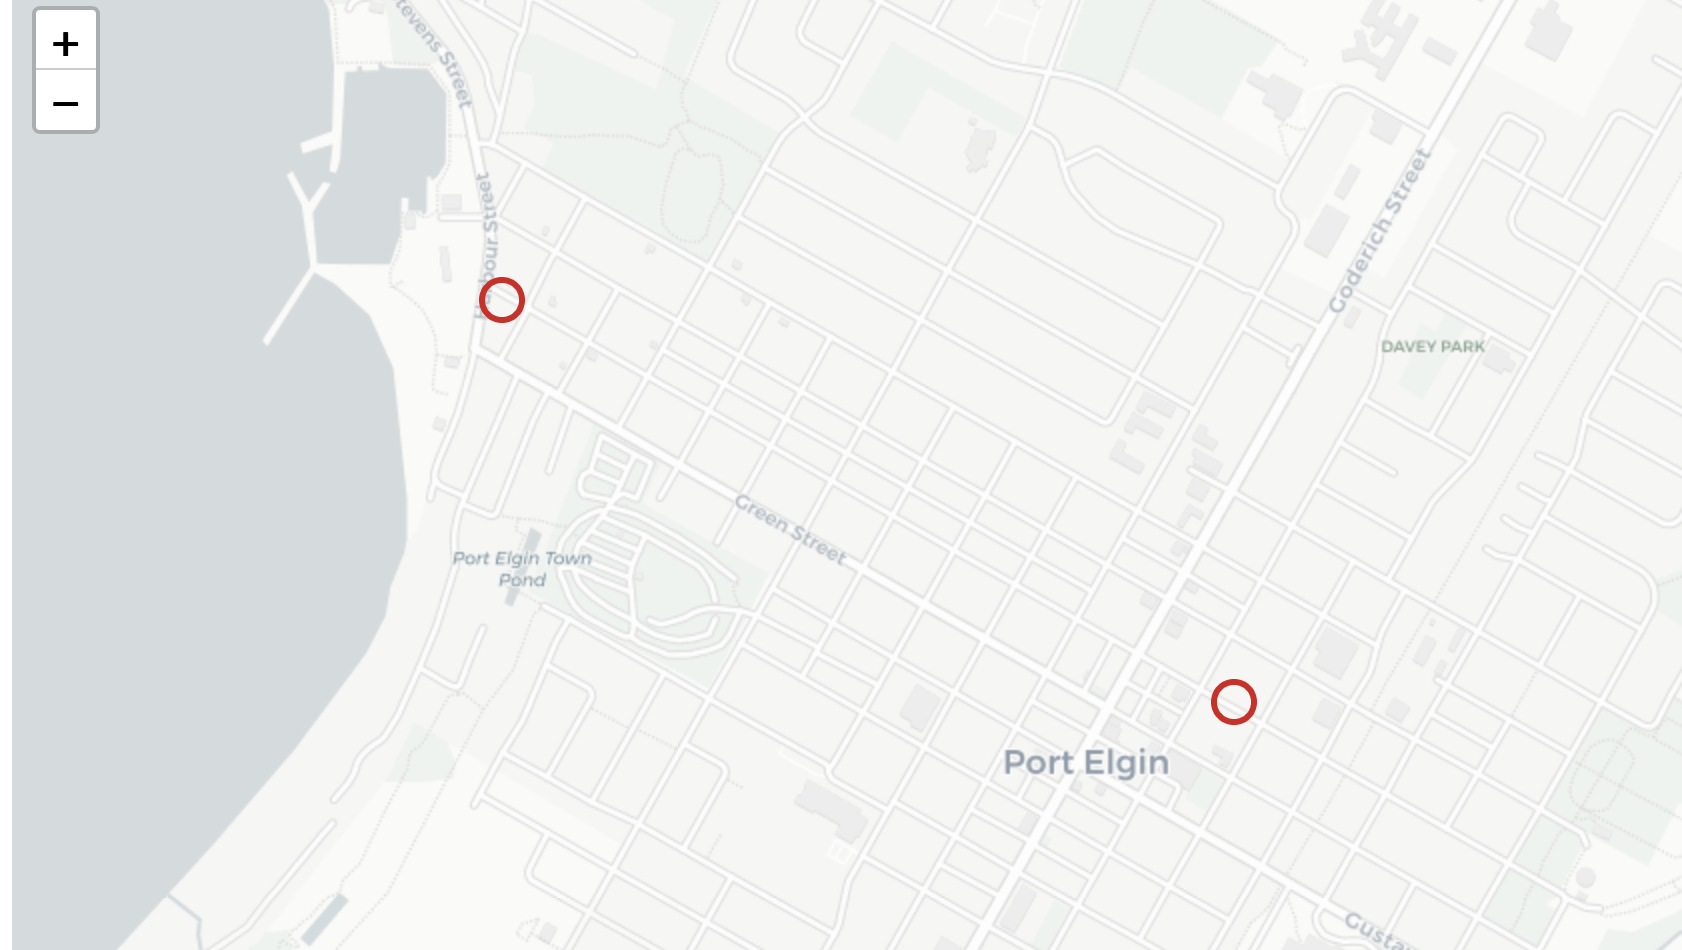

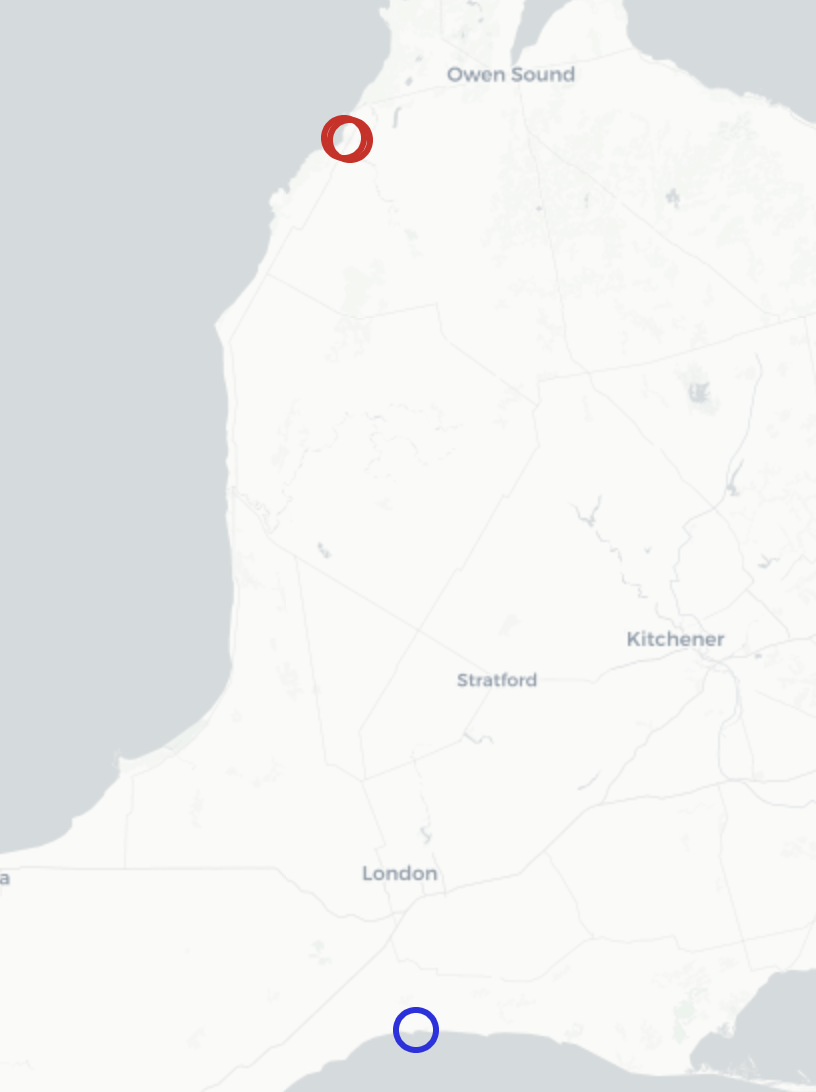

**Comments**  
From the map above, we see average ratings > 3.5 are the hotels near Green St, and that's what I recommend.

## (e)

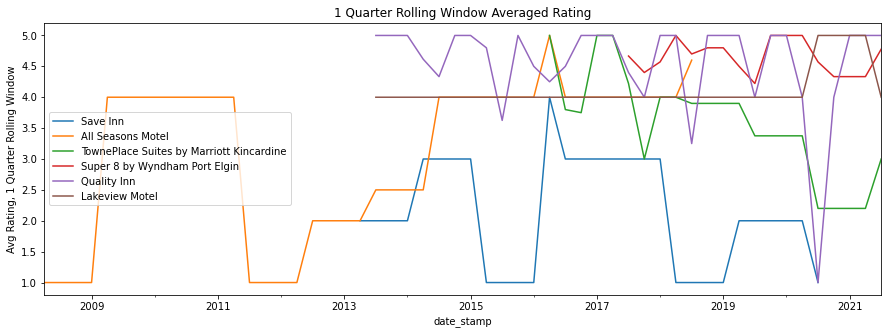

In [ ]:
hotel_collection = [
    'Save Inn', #bad
    'All Seasons Motel', #bad
    'TownePlace Suites by Marriott Kincardine', #mediocre
    'Super 8 by Wyndham Port Elgin', #Mediocre
    'Quality Inn',#good
    'Lakeview Motel',#good    
]
fig, ax = plt.subplots(1, 1, figsize=(15,5),
                       sharex=True)
for hotel in hotel_collection: 
  _df = hotelDF[hotelDF['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index, errors='coerce')
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='Q')).agg({'ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['ratingScore'].plot(ax=ax,label=hotel)
    
ax.set_title('1 Quarter Rolling Window Averaged Rating')
ax.set_ylabel('Avg Rating, 1 Quarter Rolling Window')
plt.legend()

**Comments**  
Average hotel ratings fluctuate over time. low rated hotel such as All season hotel had good rating from 2009 to 2011, but very low in 2012 and start to rise later.  

Similary, high rated hotel such as Quality Inn also fuluate from year to year, with 2020 the lowest of 1.0



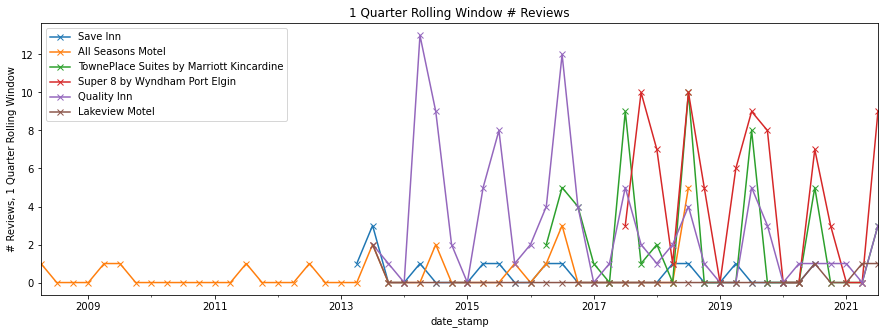

In [ ]:
ig, ax = plt.subplots(1, 1, figsize=(15,5),
                       sharex=True)

for hotel in hotel_collection: 
  _df = hotelDF[hotelDF['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index, errors='coerce')
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='Q')).agg({'count':'sum'})
  _df_monthly['count'].plot(ax=ax,label=hotel, marker='x')
    
ax.set_title('1 Quarter Rolling Window # Reviews')
ax.set_ylabel('# Reviews, 1 Quarter Rolling Window')
plt.legend()

**Comments**  
The avg number of reviews for Quality Inn is high in first years from 2014 to 2016, howevery starting from 2017 the review began to decrease. 

One hypothesis is that this hotel have a stable way of service and no big difference to the customers come again or newly visit, and people tend to not leave a review to update. Since the reviews before are good enough.